<a href="https://colab.research.google.com/github/YaZlob/ML_project/blob/master/Homework_toys_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание:

Необходимо разработать и обучить свёрточную нейронную сеть по классификации детских игрушек на языке
программирования Python c использованием библиотеки Keras (ссылка на датасет: https://disk.yandex.ru/d/NWWB9E2gMPRO7A).

Базовые задания:

1) Провести анализ и работу с данными, при необходимости - переименовать, привести к общему типу и ориентации

2) Объявить все необходимые библиотеки и методы в jupyter-notebook

3) Объявить и скомпилировать архитектуру CNN (кратко пояснить, почему выбрана именно такая архитектура)

4) Провести предобработку данных (можно пользоваться уже написанным шаблоном ниже, либо произвести предобработку
   самостоятельно по аналогии с тем, что было рассказано на лекции). Разбить данные на обучение и тестирование
   
5) Обучить сеть (подсказка: для ускорения обучения лучше при предобработке данных понизить разрешение)

6) Вывести график ошибки на обучении и тестировании

7) Сделать выводы о качестве работы сети

8) Продемонстрировать работу сети на тестовых данных

9) Сохранить нейронную сеть

Доп. задания:

1) Произвести аугментацию данных (любым возможным способом)

2) Попробовать поэкспериментировать с архитектурой CNN и подобрать более оптимальные параметры,
   чтобы сеть демонстрировала более высокое качество

Каждый из проделанных этапов желательно сопровождать краткими комментариями

In [ ]:
# все сделано на pytorch )

In [ ]:
#Открыл доступ google drive для google colab 
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
!pip install pyheif

     |████████████████████████████████| 8.2MB 6.7MB/s 


In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pyheif
import io
import copy

#from torch.utils.tensorboard import SummaryWriter
from matplotlib import colors, pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import models
from tqdm import tqdm_notebook
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# фикрсируем случайные величины (опционально)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
# чтение датасета и запись отдельно в папку dataset
!unzip -q /content/gdrive/My\ Drive/HW.zip -d dataset


In [ ]:
#create label list
label_list = os.listdir(path="dataset/HW")
Lencoder = LabelEncoder()
Lencoder.fit_transform(label_list)
Lencoder.classes_

array(['1. Обезьяна', '10. Муравьед', '11. Коала',
       '12. Плащевидная ящерица', '2. Крокодил', '3. Дельфин',
       '4. Лягушки', '5. Осьминог', '6. Попугай', '7. Черепаха',
       '8. Вомбат', '9. Кенгуру'], dtype='<U23')

In [ ]:
class ToyDataset():
  def __init__(self,label_encoder,folders,folders_name):
    self.label_encoder = label_encoder
    self.folders = folders
    self.folders_name = folders_name

  def load_image(self, file_name):
    try:
      image = Image.open(file_name)
      image = image.resize((512,512))
      return image
    except:
      heif_file = pyheif.read(file_name)
      image = Image.frombytes(heif_file.mode,heif_file.size , heif_file.data, "raw")
      image = image.resize((512,512))
      return image
      
  def create_dataset(self):
    _ = []
    for folder,name in zip(self.folders, self.folders_name):
      print(f"Загружаю {name}")
      label = self.label_encoder.transform([name])
      images = os.listdir(folder)

      for image in images:
        path = folder+r"/"+image 
        im = self.load_image(path)
        _.append([im, label[0]])

    return _  

In [ ]:
# создание списка папок (для загрузки датасета)
base_path = "dataset/HW/"
folders = [base_path+str(x) for x in os.listdir(base_path)]


In [ ]:
#load dataset
dataset = ToyDataset(label_encoder = Lencoder, folders = folders,folders_name = label_list )
data = dataset.create_dataset()


Загружаю 3. Дельфин
Загружаю 1. Обезьяна
Загружаю 2. Крокодил
Загружаю 11. Коала
Загружаю 10. Муравьед
Загружаю 5. Осьминог
Загружаю 12. Плащевидная ящерица
Загружаю 8. Вомбат
Загружаю 9. Кенгуру
Загружаю 4. Лягушки
Загружаю 6. Попугай
Загружаю 7. Черепаха


In [ ]:
type(data[0][0])

PIL.Image.Image

In [ ]:
# Разделение датасета на валидационнуюЮтестовую и тренеровочную выборки
from sklearn.model_selection import train_test_split
trains_dataset, val_test_dataset = train_test_split(data,test_size = 0.40, shuffle =True)
val_dataset, test_dataset = train_test_split(val_test_dataset, test_size = 0.5, shuffle = False)


In [ ]:
print(f"Размер тренировочного датасета {len(trains_dataset)} изображений")
print(f"Размер валидационного датасета {len(val_dataset)} изображений")
print(f"Размер тестового датасета {len(test_dataset)} изображений")

Размер тренировочного датасета 609 изображений
Размер валидационного датасета 203 изображений
Размер тестового датасета 203 изображений


In [ ]:
def show_image(im_list,label_encoder):
  n_images = 9
  random_index = np.random.randint(low = 0,high = len(im_list), size = 9)
  fig = plt.figure(figsize=(16,16))
  for i in range(n_images):
    a = fig.add_subplot(3, 3, i + 1)
    image, label = im_list[random_index[i]]
    plt.imshow(image)
    a.set_title(label_encoder.inverse_transform([label]))
  plt.show()

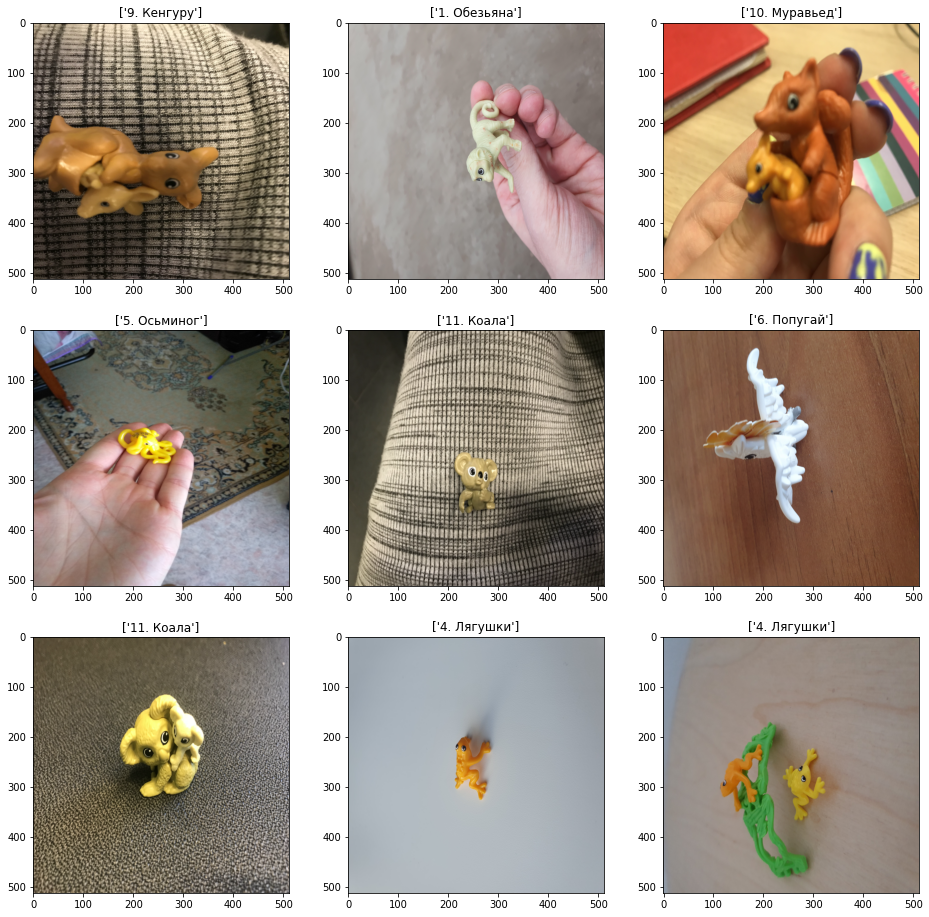

In [ ]:
#Покажем некоторые изображения из датасета
show_image(trains_dataset,Lencoder)

Для начала обучу нейронную сеть на основе архитектуры VGG19

In [ ]:
# Аугментация
test_val_transform = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_transform = transforms.Compose([transforms.CenterCrop(size = 400),
                                      transforms.Resize(size = 256), 
                                      transforms.RandomPerspective(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomGrayscale(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# P.S. Выбор именно этих пораметров mean u std обусловлен тем,
# что для всех моделей (из модуля models) использовались эти параметры нормировки
for i in range(len(trains_dataset)):
  trains_dataset[i][0] = train_transform(trains_dataset[i][0])
for i in range(len(val_dataset)):
  val_dataset[i][0] = test_val_transform(val_dataset[i][0])
for i in range(len(test_dataset)):
  test_dataset[i][0] = test_val_transform(test_dataset[i][0])


Теперь сформируем датасет, на котором будем обучать нейронную сеть

In [ ]:
train_loader = DataLoader(trains_dataset,
                          batch_size = 50,
                          num_workers = 2)
val_loader = DataLoader(val_dataset,
                         batch_size = 50,
                         num_workers = 2)
test_loader = DataLoader(test_dataset,
                         batch_size = 25,
                         num_workers = 2)


Загрузка модели

In [ ]:
#Выбор именно этой модели обусловлен тем, что:
#1 Эта архитектура НС победила в соревновании по классификации ImageNet
#2 Используется несколько слоев свертки, что дает больше карт признаков
#3 Лень писать собственную сеть, когда сотрудники Стенфорда, уже написали VGG
model = models.vgg19(pretrained=True)
model.fc = nn.Sequential(
                         nn.BatchNorm1d(1000),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(1000,12))
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


В коде не отображено, но я изменял параметры модели lr, менял классификатор, который представлен в форме Sequential (изначально просто применял линейный слой (Linear(1000,12)), пробовал также понижать количество нейронов скрытого слоя до 100, а потом только до 12.

In [ ]:
image = train_loader.dataset[0][0]
#image = image.unsqueeze(0)
#pred = model(image)

Структура модели

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
def train_mode(model, criterion, optim, loader):
  train_loss, train_acc, processed_data = 0, 0, 0
  model.train()

  for image, label in loader:
    image, label = image.to(device), label.to(device)
    optim.zero_grad()
    pred = model(image)
    loss = criterion(pred,label)
    loss.backward()
    optim.step()

    predict = torch.argmax(pred,1)
    train_loss += loss.item() * image.size(0)
    processed_data += image.size(0)
    train_acc += (predict == label).sum()
  
  return (train_loss/float(processed_data), train_acc/float(processed_data))

def test_mode(model, criterion, loader):
  test_loss, test_acc, processed_data = 0, 0, 0
  model.eval()
  best_loss = 100
  for image, label in loader:
    image, label = image.to(device), label.to(device)
    with torch.set_grad_enabled(False):
      pred = model(image)
      loss = criterion(pred,label)
      predict = torch.argmax(pred,1)
    processed_data += image.size(0)
    test_loss += loss.item()
    test_acc += (predict == label).sum()
    
  return (test_loss/float(processed_data), test_acc/float(processed_data))


In [ ]:
def loop(model, criterion, optim, train_loader, test_loader, num_epochs):
  hist = []
  path = "dataset/ModelCallback/"
  #os.mkdir(path)
  best_loss = 100.
  for epoch in tqdm_notebook(range(num_epochs)):
    train = train_mode(model, criterion, optim, train_loader)
    test = test_mode(model, criterion, test_loader)
    hist.append((train,test))
    # uncomment if you need checkpoint model
  """
      checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optim.state_dict()}

      torch.save(checkpoint, f'{path}{test[0]}.pth')
  """
    
  return hist

In [ ]:
history = loop(model.to(device), loss_fn, optimizer,train_loader, val_loader,35)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: ignored

In [ ]:
train_data , val_data = zip(*history)
def show_graph(data:list, mode = None):
  loss, acc = zip(*data)
  plt.figure(figsize=(15,15))
  plt.plot(loss, label = f"{mode} loss")
  plt.plot(acc, label = f"{mode} acc")
  plt.legend(loc = "best")
  plt.xlabel("epochs")


In [ ]:
show_graph(train_data, mode = "train")

In [ ]:
show_graph(val_data, "val")

In [ ]:
def model_accuraccy(model,data_loader):
  acc, processed_data = 0, 0
  model.cpu()
  for image, label in data_loader:
    pred = model(image)
    predict = torch.argmax(pred,1)
    acc += (predict == label).sum()
    processed_data += image.size(0)
  return acc/float(processed_data)
  

Определим точность на тестовой выборке

In [ ]:
accuracy = 100* model_accuraccy(model, test_loader)
print(f"Точность нейронной сети :{accuracy}%")

Сделаем предсказания наглядно

In [ ]:
def transform_image(image:torch.Tensor, mean :list, std:list):

  image = image * torch.tensor(std).view(3, 1, 1)
  image = image + torch.tensor(mean).view(3, 1, 1)
  image = transforms.ToPILImage(mode='RGB')(image)
  return image

In [ ]:
def show_predict(model,loader,label_encoder):
  model.cpu()
  num_image = 9
  fig = plt.figure(figsize=(16,16))
  random_index = np.random.randint(0, len(test_dataset),size=9)
  for i in range(num_image):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, _ = loader.dataset[random_index[i]]
    image_for_graph = copy.deepcopy(image)
    image = image.unsqueeze(0)
    pred = model(image)
    predict = pred.argmax(1)
    # part of visualization
    image_for_graph = transform_image(image_for_graph,[0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    plt.imshow(image_for_graph)
    a.set_title(label_encoder.inverse_transform([predict.numpy()]))

  

In [ ]:
show_predict(model,test_loader,Lencoder)

In [ ]:
# Сохранение модели
torch.save(model, f"dataset/{accuracy}.pth")

Нейронная сеть, построенная на архитектуре VGG19, имеет точность от 90 до 95 процентов в зависимости от разделения датасетов на тренировочный, валидационный и тестовый. Ошибки предсказания возникают, когда на фотографии игрушка сливается с фоном и ее сложно в принципе увидеть или в случае, когда выбран неудачный ракурс, в остальных случаев я не заметил ошибки.
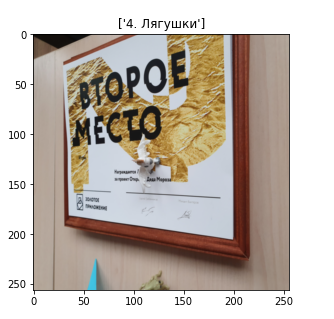
Точность предсказания можно увеличить, если обучать модель на большем количестве итераций (возможно, это не точно, может быть она начнет переобучаться,я не проверял) или при использовании ансамбля алгоритмов.   